In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras as K

from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import activations
from keras.callbacks import LearningRateScheduler

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from keras.preprocessing.image import load_img
from keras.preprocessing import image

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
train_dir = '/content/drive/MyDrive/Train/'
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
                                  )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    subset = 'training',
                                                    shuffle = True)

validation_dir = train_dir
validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        validation_split = 0.1
                                        )
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=16,
                                                              subset = 'validation',
                                                              class_mode ='categorical',
                                                              target_size=(224,224),
                                                              shuffle = True)

test_dir = '/content/drive/MyDrive/Test/'
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  )
test_generator =test_datagen.flow_from_directory(test_dir,
                                                              batch_size=16,
                                                              class_mode ='categorical',
                                                              target_size=(224,224),
                                                              shuffle = True)

Found 8795 images belonging to 2 classes.
Found 976 images belonging to 2 classes.
Found 1472 images belonging to 2 classes.


In [ ]:
base_model= K.applications.resnet.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(224,224,3), classes = 2
)

for layer in base_model.layers :
  layer.trainable = False

#base_model.summary()

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
s


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
labels = test_generator.classes
preds = model.predict(test_generator)
correct = 0
for i in range(labels.size):
  ilabel = 1
  if preds[i][0] > preds[i][1]:
    ilabel = 0
  if labels[i] == ilabel :
    correct = correct + 1

print(correct/ (labels.size))

0.1983695652173913


In [ ]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['acc'])
history = model.fit(train_generator,
                    shuffle = True,
                    epochs=5,
                    workers = 8,
                    verbose=True,
                    validation_data=validation_generator)

Epoch 1/5
550/550 [==============================] - 317s 566ms/step - loss: 0.6933 - acc: 0.5688 - val_loss: 0.5645 - val_acc: 0.7377
Epoch 2/5
550/550 [==============================] - 103s 184ms/step - loss: 0.6547 - acc: 0.6273 - val_loss: 0.5220 - val_acc: 0.7992
Epoch 3/5
550/550 [==============================] - 104s 185ms/step - loss: 0.6542 - acc: 0.6250 - val_loss: 0.5463 - val_acc: 0.7367
Epoch 4/5
550/550 [==============================] - 103s 185ms/step - loss: 0.6402 - acc: 0.6419 - val_loss: 0.5241 - val_acc: 0.7838
Epoch 5/5
550/550 [==============================] - 103s 185ms/step - loss: 0.6363 - acc: 0.6485 - val_loss: 0.5216 - val_acc: 0.7838


[0.5959067940711975, 0.6286526322364807, 0.6339966058731079, 0.6445707678794861, 0.6486639976501465]
[0.7377049326896667, 0.7991803288459778, 0.7366803288459778, 0.7838114500045776, 0.7838114500045776]


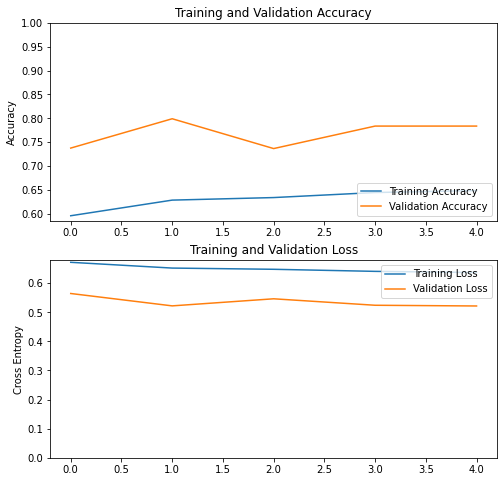

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [ ]:
fine_tune_at = 75
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 22,156,034
Non-trainable params: 1,435,776
_________________________________________________________________


In [ ]:
#callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = True)
my_callbacks = [
  tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=3, verbose=True,
    mode='auto', min_delta=0.000001, cooldown=0, min_lr=0 
  )]

In [ ]:
history = model.fit(train_generator,
                    shuffle = True,
                    epochs=20,
                    workers = 8
                    ,
                    verbose=True,
                    validation_data=validation_generator,
                    callbacks = my_callbacks)

Epoch 1/20
550/550 [==============================] - 114s 200ms/step - loss: 0.5853 - accuracy: 0.7051 - val_loss: 0.6422 - val_accuracy: 0.6803
Epoch 2/20
550/550 [==============================] - 110s 197ms/step - loss: 0.4033 - accuracy: 0.8231 - val_loss: 0.3200 - val_accuracy: 0.8617
Epoch 3/20
550/550 [==============================] - 110s 198ms/step - loss: 0.3502 - accuracy: 0.8485 - val_loss: 0.2800 - val_accuracy: 0.8955
Epoch 4/20
550/550 [==============================] - 112s 200ms/step - loss: 0.3008 - accuracy: 0.8757 - val_loss: 0.2824 - val_accuracy: 0.8904
Epoch 5/20
550/550 [==============================] - 110s 197ms/step - loss: 0.2677 - accuracy: 0.8944 - val_loss: 0.2032 - val_accuracy: 0.9314
Epoch 6/20
550/550 [==============================] - 111s 197ms/step - loss: 0.2432 - accuracy: 0.9004 - val_loss: 0.1559 - val_accuracy: 0.9324
Epoch 7/20
550/550 [==============================] - 110s 198ms/step - loss: 0.2168 - accuracy: 0.9167 - val_loss: 0.1537 -

In [ ]:
labels = test_generator.classes
preds = model.predict(test_generator)
correct = 0
for i in range(labels.size):
  ilabel = 1
  if preds[i][0] > preds[i][1]:
    ilabel = 0
  if labels[i] == ilabel :
    correct = correct + 1

print(correct/ (labels.size))

0.6555706521739131


In [ ]:
correct = 0
for i in range(92) :
  test_x, test_y = test_generator.__getitem__(i)
  preds = model.predict(test_x)
  for i in range(preds.shape[0]):
    if np.argmax(preds[i]) == np.argmax(test_y[i]):
      correct += 1
print( correct/ test_generator.n)

0.9055706521739131


Neutral


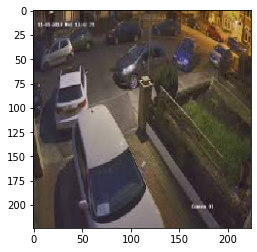

In [ ]:
labels = test_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
image_path = '/content/drive/MyDrive/nofire1.jpg'
img = load_img(image_path, target_size = (224, 224))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255
p = model.predict(x)
#print(p)
i = np.argmax(p,1).squeeze()
i = int(i)
print(labels[i])

In [ ]:
model.save('fd.h5')

In [ ]:
model.save("FireDetection")

INFO:tensorflow:Assets written to: FireDetection/assets
